In [171]:
import pandas as pd
import numpy as np
import umap
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',None)

## Data

In [39]:
vec=np.load('data/embeddings/embs_e5.ar.npy',  allow_pickle=True)

In [40]:
vec.shape

(413761, 768)

In [23]:
texts=pd.read_csv('data/embeddings/embs_text_e5.csv')
texts.shape

(413761, 1)

In [26]:
texts_emb=dict()
for i, t in enumerate(texts.text_splitted.tolist()):
    texts_emb[t]=vec[i]

In [27]:
len(texts_emb)

413761

In [28]:
df_orig=pd.read_csv('data/raw/stenos_cleaned_faction2022_topics.csv')
df_orig.shape

(465494, 27)

In [213]:
df_orig.Name_red_outliers

0         273_kohaloleku_kontroll_arupärimisi_töönädala
1         1243_ettekanne_teostamisel_minutit_tegevusest
2          207_ettekanne_sõnavõttudega_minutit_vastused
3               139_ammendumiseni_pikendada_kauem_kella
4                 1461_maksude_maksud_maksudega_mängita
                              ...                      
465489                91_jõuluvana_aplaus_naer_luuletus
465490                91_jõuluvana_aplaus_naer_luuletus
465491                91_jõuluvana_aplaus_naer_luuletus
465492                                   -1_ma_te_me_et
465493                91_jõuluvana_aplaus_naer_luuletus
Name: Name_red_outliers, Length: 465494, dtype: object

In [33]:
df_orig[~df_orig.fation.isnull()].shape

(232059, 27)

In [35]:
df_orig.fation.value_counts()

Eesti Reformierakonna fraktsioon                    50485
Eesti Keskerakonna fraktsioon                       48313
Eesti Konservatiivse Rahvaerakonna fraktsioon       37919
Sotsiaaldemokraatliku Erakonna fraktsioon           31078
Isamaa fraktsioon                                   23842
Isamaa ja Res Publica Liidu fraktsioon              12894
Eesti Vabaerakonna fraktsioon                       11268
Fraktsiooni mittekuuluvad saadikud                   7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed     5618
Erakonna Eestimaa Rohelised fraktsioon               1362
Eestimaa Rahvaliidu fraktsioon                       1050
Eesti 200 fraktsioon                                  295
Name: fation, dtype: int64

## Keep some faction texts

In [69]:
factions2keep=['Eesti Reformierakonna fraktsioon','Eesti Keskerakonna fraktsioon',
               'Eesti Konservatiivse Rahvaerakonna fraktsioon','Sotsiaaldemokraatliku Erakonna fraktsioon',
               'Isamaa fraktsioon', 'Isamaa ja Res Publica Liidu fraktsioon', 'Eesti Vabaerakonna fraktsioon',
              'Erakonna Eestimaa Rohelised fraktsioon', 'Eestimaa Rahvaliidu fraktsioon',
              'Eesti 200 fraktsioon', 'Fraktsiooni mittekuuluvad saadikud',
              'Fraktsioonidesse mittekuulunud Riigikogu liikmed']

df_orig_faction=df_orig[df_orig.fation.isin(factions2keep)]
df_orig_faction.shape

(232059, 27)

## Calculate attention

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Example class for attention-based aggregation of text embeddings
class AttentionAggregator(nn.Module):
    def __init__(self, embedding_dim):
        super(AttentionAggregator, self).__init__()
        # Define a linear layer for computing attention scores
        self.attention_layer = nn.Linear(embedding_dim, 1)
        
    def forward(self, embeddings):
        """
        embeddings: Tensor of shape (n_texts, embedding_dim)
        This represents the text embeddings for a single speaker.
        """
        # Compute attention scores
        attention_scores = self.attention_layer(embeddings)  # Shape: (n_texts, 1)
        attention_scores = attention_scores.squeeze(1)  # Shape: (n_texts)
        
        # Apply softmax to get normalized attention weights
        attention_weights = F.softmax(attention_scores, dim=0)  # Shape: (n_texts)
        
        # Compute the weighted sum of the embeddings
        weighted_embeddings = embeddings * attention_weights.unsqueeze(1)  # Shape: (n_texts, embedding_dim)
        speaker_embedding = torch.sum(weighted_embeddings, dim=0)  # Shape: (embedding_dim)
        
        return speaker_embedding, attention_weights

In [219]:
faction_emb=dict()
faction_weights=dict()
faction_texts=dict()
embedding_dim = vec.shape[-1]
faction_topics=dict()

for faction  in factions2keep:
    print(faction)
    df_fac_=df_orig_faction[df_orig_faction.fation==faction]
    texts_=df_fac_.text_splitted
    faction_topics[faction]=df_fac_.Name_red_outliers.tolist()
    faction_texts[faction]=texts_.copy()
    print(f'no of texts {texts_.shape[0]}')
    # texts_ids_ = texts[texts['text_splitted'].isin(texts_)].index
    # text_embeddings=torch.tensor(vec[texts_ids_])
    text_embeddings=torch.tensor(np.array([texts_emb[t] for t in texts_]))

    # Create the attention aggregator model
    aggregator = AttentionAggregator(embedding_dim)

    # Aggregate the embeddings using the attention mechanism
    faction_embedding, attention_weights = aggregator(text_embeddings)
    faction_emb[faction]=faction_embedding
    faction_weights[faction]=attention_weights

Eesti Reformierakonna fraktsioon
no of texts 50485
Eesti Keskerakonna fraktsioon
no of texts 48313
Eesti Konservatiivse Rahvaerakonna fraktsioon
no of texts 37919
Sotsiaaldemokraatliku Erakonna fraktsioon
no of texts 31078
Isamaa fraktsioon
no of texts 23842
Isamaa ja Res Publica Liidu fraktsioon
no of texts 12894
Eesti Vabaerakonna fraktsioon
no of texts 11268
Erakonna Eestimaa Rohelised fraktsioon
no of texts 1362
Eestimaa Rahvaliidu fraktsioon
no of texts 1050
Eesti 200 fraktsioon
no of texts 295
Fraktsiooni mittekuuluvad saadikud
no of texts 7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed
no of texts 5618


## plot vectors

In [204]:
faction_emb_ar=np.vstack([faction_emb[faction].detach().numpy() for faction in factions2keep])
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(faction_emb_ar)

/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [205]:
faction_emb_ar.shape

(12, 768)

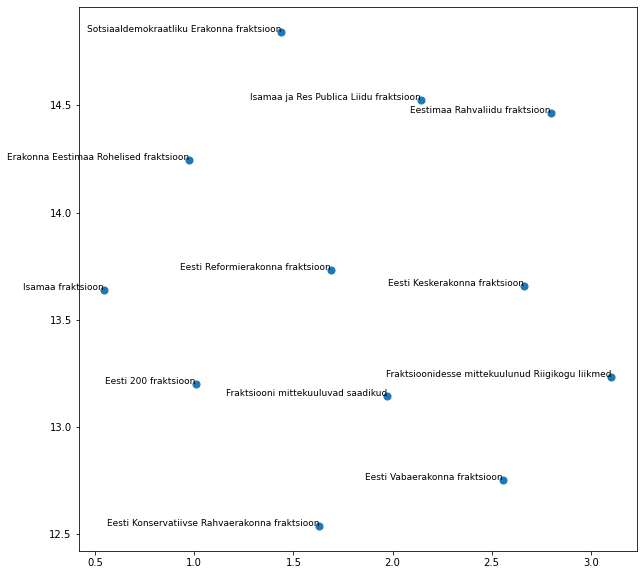

In [242]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

### try to calculate correlation of x- and y-axis and the word frequency

In [243]:
def find_word_score_corr(faction_texts, factions2keep, scores):
    vectorizer = CountVectorizer(stop_words=None)
    X = vectorizer.fit_transform([faction_texts[faction].values[0] for faction in  factions2keep])  # Word count matrix
    words = vectorizer.get_feature_names_out()  # Get the list of words

    # Step 2: Convert X to a DataFrame for easier analysis
    word_counts = pd.DataFrame(X.toarray(), columns=words)

    # Step 3: Calculate Correlation between Word Frequency and Score
    correlations = {}
    for word in words:
        word_frequency = word_counts[word]
        correlation, _ = spearmanr(word_frequency, scores)  # Spearman correlation between word freq and score
        correlations[word] = correlation

    # Step 4: Create a DataFrame with words and their correlation with score
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['word', 'correlation'])

    # Step 5: Sort by correlation to find the words most correlated with high and low scores
    correlation_df = correlation_df.sort_values(by='correlation', ascending=False)
    return correlation_df

In [244]:
find_word_score_corr(faction_texts, factions2keep, reduced_embeddings[:, 0]).head(30)

,word,correlation
14,ajal,0.647750
510,vaja,0.647750
24,aru,0.582975
514,valitsus,0.521430
276,ning,0.518200
245,minister,0.518200
571,ütlesite,0.518200
481,tulumaksu,0.480384
30,arvestuslikult,0.480384
219,maksumuudatus,0.480384


In [245]:
find_word_score_corr(faction_texts, factions2keep, reduced_embeddings[:, 1]).head(30)

,word,correlation
337,proua,0.647750
90,euroopa,0.614990
72,enne,0.582975
520,vastu,0.521430
319,pensioniiga,0.510679
50,eelarveläbirääkimist,0.480384
297,omavahendeid,0.480384
526,veel,0.480384
151,kontekstis,0.480384
524,vastuvõetavad,0.480384


### find x and y score and topic relationship

In [246]:
# faction_topics_l=[faction_topics[faction] for faction in  factions2keep]
# faction_topics_l_flat=[item for sublist in faction_topics_l for item in sublist]

df_scores=pd.DataFrame()
for i, faction in enumerate(factions2keep):
    faction_topics_l_=faction_topics[faction]
    faction_scores=reduced_embeddings[i, 0]
    df_score_=pd.DataFrame({'topic':faction_topics_l_, 'score':[faction_scores for _ in range(len(faction_topics_l_))]})
    df_scores=pd.concat([df_scores, df_score_], axis=0)

In [247]:
df_scores.groupby('topic').score.mean().sort_values(ascending=False)

topic
346_määranud_seisukohtade_edastanud_arvamuse                   3.103867
1064_kallas_kaja_küsija_aeg                                    3.103867
1582_pakosta_ly_liisa_jents                                    3.103867
975_kütust_paagis_auto_piiri                                   2.927336
1084_menetleja_väärteo_väärteomenetluse_kohtuvälise            2.903566
                                                                 ...   
303_hääletamissedeli_sedeli_valimiskomisjon_hääletamiskasti    0.544724
87_esindab_menetlemisel_valitsust_algatab                      0.544724
1102_jänese_vastamiseks_lukase_teadusminister                  0.544724
502_ettekanne_suulise_elluviimisest_lõppemisel                 0.544724
259_helme_martin_lisaküsimus_mart                              0.544724
Name: score, Length: 1635, dtype: float32

In [248]:
df_scores=pd.DataFrame()
for i, faction in enumerate(factions2keep):
    faction_topics_l_=faction_topics[faction]
    faction_scores=reduced_embeddings[i, 1]
    df_score_=pd.DataFrame({'topic':faction_topics_l_, 'score':[faction_scores for _ in range(len(faction_topics_l_))]})
    df_scores=pd.concat([df_scores, df_score_], axis=0)
    
df_scores.groupby('topic').score.mean().sort_values(ascending=False)

topic
751_ligil_jürgen_protseduuriline_ligi          14.842293
1766_kohaloleku_kontroll_viime_kontrolli       14.842293
1227_laurson_peeter_järvekaitse_laursonilt     14.842293
1871_kersna_liina_täpsustav_osalete            14.842293
1725_aller_järgnevalt_arvo_belobrovtsev        14.842293
                                                 ...    
524_kruuse_urmas_kruusel_täpsustav             12.537503
1717_of_and_sex_the                            12.537503
237_kert_kingo_kingol_protseduuriline          12.537503
1600_toiduabi_fairtrade_rainforest_alliance    12.537503
547_lõpetan_liikmetel_soovi_käsitlemise        12.537503
Name: score, Length: 1635, dtype: float32

### see most important texts for each faction

In [249]:
def show_mostimportant_faction_texts(faction, faction_texts, faction_weights, n=10):
    indices=faction_weights[faction].sort(descending=True).indices
    return faction_texts[faction].reset_index().iloc[indices.numpy()].head(n)

In [250]:
show_mostimportant_faction_texts('Eesti Reformierakonna fraktsioon', faction_texts, faction_weights)

,index,text_splitted
36881,317344,n-ö vaba rahaga mida valitsus saab poliitiliste prioriteetide järgi ümber suunata on see summa päris suur järgmise aasta eelarvele on iseloomulik veel see et maksutulud on koondatud kokku ühte aastasse seda tehakse mitme meetmega kõigepealt on aktsiisitulusid ajatatud nii et nad maksimaalselt laekuks järgmisel aastal uus pankade maksustamise kord toob maksukohustust ettepoole kuna pangad hakkavad maksu maksma teenitud kasumilt samuti on ettevõtjatel võimalik tulevikus saada soodsamat dividendimäära kui nad järgmistel aastatel maksavad rohkem dividende st ka dividendide maksmine tuuakse ettepoole
43870,380266,on igal juhul vaba küsimus on selles kas me näeme seal enamat kui ideoloogia on see et riigipühad on vabad päevad selleks et neid tähistada siis nagu probleemi ei ole aga küsimus on selles kas sellega ikkagi kaasneb ootus et selle võiks asendada täiendava vaba päevaga see on selle eelnõu küsimus see on kindlasti diskussiooni koht aga justiitsministeerium ja muide ka sotsiaalministeerium juhtis tähelepanu sellele et kui on eesmärk pühi tähistada siis seda takistust ei ole see üks päev on
6819,63806,aitäh hea eesistuja lugupeetud minister ettevõtjana te kindlasti teate et kohustused ehk siis võlad ei anna ettevõtte seisust kogupilti oluline on ka see millised on ettevõtte varad kui me nüüd vaatame riigi varasid ja riigi kohustusi siis me näeme et kuigi võlad on hakanud tasapisi justkui vähenema on varade vähenemine olnud nii kiire et netokohustuste hulk kasvab enam kui kaks korda kui ettevõtetega juhtuks sama siis võlausaldajad muutuksid eriti tähelepanelikuks ja eriti kurjaks nii et laenu enam ei antaks halvimal
4186,38837,õiguslik raamistik mis on seotud elektrituru avanemisega 2013. aastal mis puudutab esimest eesmärki põhivõrgu juhtimist siis on ka avalikkuse eest juba läbi käinud eelnõu raames seatav kohustus et eesti energia ja põhivõrguettevõtja elering ei tohi enam järgmise aasta 1. maist kuuluda sama ministeeriumi haldusalasse et aktsiate valitsejat tuleb muuta olgu öeldud et selle seadusega me ei ütle millise ministeeriumi haldusalasse milline ettevõte kuuluma peab selle otsuse peab valitsus langetama ise minister kinnitas komisjonis et sellekohane analüüs on tegemisel kõige olulisem
17407,152613,ei või kuna tegemist on riigikogu kodu- ja töökorra seaduse muutmisega
40007,347949,vähem bürokraatlikumaks muutuma mil moel ja millal need kergendused tulevad ja mis on teie sõnum ettevõtjatele peale selle et makske võimalikult palju makse ära
35586,308823,tsiviilkohtumenetluse seadustiku ja täitemenetluse seadustiku rakendamise seaduse ning tsiviilseadustiku üldosa seaduse muutmise seaduse eelnõu 713 tekstiga mille valmistas ette riigikogu õiguskomisjon ja seletuskiri vastab põhiosas sellesama eelnõu 713 algteksti seletuskirjale kuna see valitsuse eelnõu oli äsja riigikogu menetluses siis ei hakka ma väga pikalt üle kordama eesmärke mida me üritame selle seaduseelnõuga saavutada peamine põhjus on aga kindlasti laenuvõtja kaitsmine ebamõistlikult kõrge krediidi kulukuse määra eest et laenuandjal ei oleks võimalik ära kasutada laenuvõtja sellist situatsiooni kus ta on hätta
43502,375544,tekib valimiste järel vähemalt paar aastat poliitika rakendamise aega ja siis järgneb n-ö vahevalimise aasta näiteks euroopa parlamendi valimiste näol loodetavasti kasvab seetõttu ka valimisaktiivsus euroopa parlamendi valimistel nii et vahevalimisteks tuleb uue korra järgi pidadagi teisi valimisi mis siis järgnevad annan nüüd teile ülevaate ka paragrahvidest mida algatajad plaanivad muuta esiteks algatajate ettepanek on sõnastada põhiseaduse § 60 lõige 3 järgmiselt riigikogu korralised valimised toimuvad märtsikuu esimesel pühapäeval neljandal aastal mis järgneb riigikogu eelmiste korraliste valimiste aastale. erinevus praegusest
31840,275515,esimene lugemine toimus 11. juunil muudatusettepanekute esitamise tähtajaks määrati 17. juuni kell 17 ja esitati üks muudatusettepanek see oli eesti keskerakonna frak

In [251]:
show_mostimportant_faction_texts('Eesti Keskerakonna fraktsioon', faction_texts, faction_weights)

,index,text_splitted
19280,180235,et kristen michal suudab anda neile adekvaatsed vastused aitäh
32233,289166,tihtipeale teatud väikesed iseärasused ja nad ei saa sellega võib-olla alati hakkama kas on ka mingi lahendus loovisikute jaoks kes ei kuulu loomeliitu
10886,98421,ei sisalda see peatükk teiste rahvusvähemuste kultuuripärandi väärtustamise sätet kas nende mitte-eestlaste panus eesti kultuuriajalikku kes ei kuulu ülalnimetatud rahvusgruppidesse ei vääri tunnustamist ja tuge
27641,247575,kuidas sellesse elektroonilisse abieluvarasüsteemi puhtpraktiliselt neid andmeid sisse kantakse veel üks konkreetne küsimus kas mõlemad abielupooled peavad kohal olema
13695,123239,kanna pimeda ajal helkurit ja temaga midagi juhtub
22690,206302,lugupeetud eesistuja esineja küsis minult kus ma olin kas ma pean sellele küsimusele vastama ja kas ma võin sellele vastata
25799,232566,ma lähtun sellele vastates pigem oma elukogemustest ma ei kujuta ette maksuhaldurit kes n-ö käigu pealt ütleme kui auto kiirus on 60 kilomeetrit tunnis hakkab tehnikaga sekeldama pildistama või ühest autost teise hüppama seepärast eeldan 99% tõenäosusega et tegemist on seisva sõidukiga
45127,426636,tänan juhataja hea üllar ma küsin jätkuvalt eesti lipu seltsi kohta kuna ka esineja pinginaaber tarmo kruusimäe on selle seltsi liige siis võib-olla on ka kuluaarides või pingis omavahel arutatud kui hea mõte on kirjanike päeva puhul lippu heiskama hakata mitte seda ma ei taha öelda et see oleks mingi halb mõte lihtsalt kuna siin oli juttu juubelitest siis mulle tuli ootamatult meelde et järgmisel aastal kui võib-olla on esimene lipupäev on 90 aastat möödas hoopis ühest teisest sündmusest mille
31539,282892,lugupeetud istungi juhataja kas te juhiksite vastaja tähelepanu küsimusele mida küsija küsis ja kas te jälgite istungi juhatajana et vastaja vastaks küsimusele mida küsija on küsinud
3768,32842,siis hakatakse neid pühasid arutama


In [252]:
show_mostimportant_faction_texts('Sotsiaaldemokraatliku Erakonna fraktsioon', faction_texts, faction_weights)

,index,text_splitted
8551,121366,mille taha see jäi et see lõpuks valmis ei saanud
11080,149266,nad ju ainult 25 eurot tänan teid
781,13442,aga ma lõpetasin praegu
28829,425161,see et me loodame ja ootame mõistlikku hinda aga me ei oska seda täpselt öelda nii nagu ma ka ministri käest küsisin me eeldame et see hind on alla fikseeritud lepingute hinna aga see sõltub erinevatest teguritest ja muu hulgas sellest mis konkurentsiamet selle seaduse vastuvõtmise järel selleks hinnaks määrab. küll aga on koalitsioon juba ennetavalt kokku leppinud ja broneerinud raha selle jaoks et igal juhul tuleb riik appi 50 euroga megavati kohta ehk ka sellest hinnast mille konkurentsiamet määrab
30060,450239,perekonda kümne aastaga euroopas kõige kiiremini kasvanud kodude hinnad süvenev regionaalne ebavõrdsus ja üha kallim toidukorv on vaid mõned näited kuigi ka tänane valitsus on inimestele appi tulnud tänu sotsiaaldemokraatidele suurenes enam kui 100 000 töötaja töötasu ligi 400 eurot aastas palgad tõusid õpetajatel päästjatel politseinikel kultuuritöötajatel aga siit tuleb edasi minna olukord kuhu me oleme jõudnud või veidi optimistlikumatel hinnangutel jõudmas annab meile võimaluse lasta lahti aastakümneid süvenenud dogmadest täna ei aita peresid ega ettevõtjaid haava plaastriga katmine nagu
13081,179800,olud kiiresti ja tihti on neid raske ette näha valitsus isegi ei ole suutnud seda ette näha et teine laine tuleb ja peaks midagi tegema me oleme siin kuude kaupa näinud et neile hakkab see alles nüüd kohale jõudma rääkimata muudest asjadest. aga kas te saaksite öelda mida sotsiaalminister tanel kiik ja tema juhitav ministeerium sellest seaduseelnõust arvab ma loodan et sealtpoolt oli vähemalt maksimaalne tugi aga nagu ikka siis koalitsioonipartnerid ei luba avalikult toetada või mis mulje teile on
30585,457770,aitäh küsimuse eest komisjoni liikmed kohe päris alguses küsisid sedasama et milline on see eelarveline mõju üleriiklik selles osas kahjuks eelnõu esitaja jäi vastuse võlgu et seda täpset teadmist tal ei olnud kuna nagu ma ütlesin meil oli hulk kov‑i taustaga inimesi ruumis siis tõepoolest aseesimees komisjonis tõi välja selle et tallinna linn on kalkuleerinud selleks kuluks suurusjärgus 20 miljonit eurot umbes juurde arvutame mida ma tean et eelmise riigikogu koosseisu ajal tehti arvati et see võiks olla suurusjärgus 40
13421,185049,tolleaegne peaminister ansip on selge et sellised juhtumid on väga üksikud kuid aastate jooksul on 200 alaealiselt eesti kodanikult kahjuks kodakondsus siiski ära võetud andes automaatselt eesti kodakondsuse eestis sündivatele lastele kelle vanemad on eesti alalised elanikud kuid ilma kodakondsuseta lõpetame tõepoolest kodakondsusetuse taastootmise me kõik teame et sellist otsust on meilt ammu oodanud mitmesugused rahvusvahelised organisatsioonid alates üro-st julgen arvata et kui 20 aastat tagasi tulid paljud välisriigid meile vastu ja aktsepteerisid nn halli passi reisidokumendina siis ei osanud
835,14026,n-ö maksusoodustusest saavad kasu ainult need inimesed kes tulu saavad
8869,125339,seda ikka kistud tännapoole koguni kaks korda õnneks see sinna ei ole läinud kui seda poleks olnud siis poleks vajadust selle eelnõu järele tekkinud nüüd on algatajad reageerinud n-ö aktuaalsele poliitilisele olukorrale millest tulenevalt valitseb turul suur ebakindlus mis on mõneks ajaks apteegireformi rakendumist pidurdanud ma tänan


In [253]:
show_mostimportant_faction_texts('Eesti Konservatiivse Rahvaerakonna fraktsioon', faction_texts, faction_weights)

,index,text_splitted
37051,461081,saatnud palju annetusi praegu ukrainale
26709,406613,me ei tea kuhu venemaa võib esimesena lüüa palun lisaaega
28229,413651,kavatseb vastu võtta kuni 50 000 põgenikku ukrainast
10520,218739,136
17302,329240,alžiiri
6473,137581,maa läti vodkaturistidele
19823,360191,varust
28377,414410,hea juhataja hea minister süda läheb soojaks kui ma loen et te olete ette näinud 100 000 eurot lemmikloomade marutaudi vastu vaktsineerimiseks arvestades et vaktsineerimise hind on umbes 30 eurot see tähendab 3300 kassi ja koera vaktsineerimist samas oli ukrainas eelmisel aastal 153 koera marutaudis ja 146 kassi ja lemmikloomi on seal 8 miljonit kokku ja nüüd kui nad tulevad siia koos põgenikega siis 100 000 eurot on selleks ette nähtud ma küsin kust te need arvestused võtsite ja kas
12646,236994,aitäh lugupeetud kultuuriminister olete toetanud mõtet nimetada okupatsioonide muuseum ümber vabaduse muuseumiks ehk vabamuks see mõte on leidnud ühiskonnas laialdast hukkamõistu sest see on märk lugupidamatusest meie ajaloo vastupanuvõitluse ning kümnete tuhandete inimeste kannatuste vastu okupatsiooniaegse genotsiidi ja venestamispoliitika käigus need on asjad mida ei tohi unustada ammugi mitte vabaduse lipu alla peita ümbernimetamise kohta on teilt küsitud ka varem kuid ma küsin nüüd kas avalikkuse vastuseis ei ole teid pannud oma seisukohta revideerima kas teie arvates on käes aeg
34465,445506,kus taevas kuulub vene õhuväele


In [254]:
show_mostimportant_faction_texts('Eesti 200 fraktsioon', faction_texts, faction_weights)

,index,text_splitted
157,409327,et saavad oma laste eest hoolitseda siis nad neid lapsi saavad nad saavad neid lapsi ka päris mitu mul on hea näide ühest sõbrannast kes sai oma esimese lapse 31-aastaselt nüüd on ta 34 ja kohe-kohe sünnitab oma kolmanda see asi on natuke edasi lükkunud ei saada enam 22-aastaselt lapsi aga praegu on see auk tulnud sellest et meie ühiskond on läinud vabamaks ja inimestel on rohkem valikuid ma tahtsin ka toonitada et raha või peretoetuseid vähendatakse mitte ei kaotata
274,457620,austatud istungi juhataja head kolleegid komisjon arutas teemat päris pikalt ja teen võrdlemisi põhjaliku ülevaate palun kannatust põhiseaduskomisjon arutas eelnõu 262 oe oma neljapäevasel 14. septembri istungil lisaks komisjoni liikmetele osales istungil selle eelnõu esitaja esindaja tanel kiik kes tutvustas komisjonile eelnõu ning vastas komisjoni liikmete küsimustele eelnõu esitaja esindaja selgitas ammendavalt eelnõu sisu ja sellel ma pikemalt ei peatu komisjonis toimus järgmine arutelu alustuseks sõnas üks komisjoni liige et ei mõista miks on sellel teemal uurimiskomisjoni loomine vajalik ta
58,387675,olenemata vanaduspensioniealise inimese kogutulu suurusest tulumaksuvabaks jumal missugune lause kuuendaks maksti eelmise aasta sügisel 200‑eurost üksi elava pensionäri toetust mida makstakse ka järgnevatel aastatel 2023. aasta alguses suurendati represseeritutele makstavat toetust 230 eurolt 292 euroni ja hinnatõusu leevendamiseks maksti eelmise aasta novembrikuus ühekordset toetust 50 eurot sotsiaalkomisjoni istungil arutati keskerakonna fraktsiooni ettepanekut komisjoni liikmed küsisid mitmeid küsimusi ja eelkõneleja nendest ka rääkis komisjoni liikmed tundsid ka huvi missugused on vabariigi valitsuse või sotsiaalkaitseministri ettepanekud ja plaanid pensionide kohta vastusena kuulsime
286,457632,siemann timo suslov hendrik johannes terras urve tiidus vastu olid ants frosch andrei korobeinik helir-valdor seeder ja aleksandr tšaplõgin erapooletuid ei olnud aitäh
250,438544,arendada ka siiski regionaalhaigla just ennekõike perh-i näol kokkuvõtteks ma ütleks et jah ma olen nõus tallinn ja tallinna inimesed kindlasti vajavad linnahaiglat aga kindlasti ei peaks see haigla konkureerima juba olemasolevate regionaalhaiglatega nii et me vajame pigem sellist kohalikku või mitte kohalikku haiglat vaid keskhaiglat kui piirkondlikku haiglat olles terminoloogias korrektne aitäh teile
154,409278,teise last aidata üles kasvatada aitäh
126,407406,oleks või tekiks võimalus sõja võitmiseks margus tsahkna minu küsimus puudutab meie euroopa liitlasi juhataja helistab kella. milline on teie informatsioon selle kohta kuidas meie euroopa liitlased saavad täpselt samamoodi kaasa aidata sellele milline on teie viimane teadmine selles osas
115,405456,kõik jõuda selleni et eesti mitte ainult koolinoored vaid eesti tervikuna ei oleks üks kõige suuremaid toidu raiskajaid euroopa liidus kas me suudaksime jõuda selleni et heakene küll kui meil jääb mõnikord midagi üle et see jõuaks õigesse kohta kas uuesti mullaks või siis biokütuseks või milleks iganes ta siis parasjagu kõlbulik on et me saame selle asja ühiskonnas parandada kas me jõuaks üheskoos selleni et me saaksime koolinoorte abil olla suure sammu edasi astunud mitte aastate pärast vaid palju
105,404314,eelduste maksmapanemisel tarbekorral ka sügavaid kitsendusi läbi viime selleks et abielu ei saaks tõu halvenemise allikaks. see tõnissoni ettepanek toetust ei leidnud abiellu astumise piiranguteks jäid parandamata vaimuhaigused raskel kujul langetõbi pidalitõbi ja suguhaigused haiguse külgehakkavuse järgus aga lahutus tuli ja võrdõiguslikkus ka tuletagem meelde siis ikkagi leppisid meie eelkäijad siinsamas saalis kokku senine abielu pühadus ära muuta põhimõtteliselt ja ilmalikult võrdõiguslikuks kardeti küll mitmel korral siinsamas saalis et selline abielu pühaduse rikkumine nagu lahutuse lubamine ja naiste võrdõiguslikuks aitamine
215,434261,austatud istungi juhataja head kolleegid vastavalt

## Autoencoder

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: maps the input to a latent space (lower-dimensional representation)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder: reconstructs the input from the latent space representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Use Sigmoid if the input embeddings are normalized between 0 and 1; otherwise, omit this.
        )
        
    def forward(self, x):
        # Forward pass through encoder and decoder
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

#### Example usage

In [137]:
# Example: Simulate embeddings for 3 different speakers, each with a different number of texts
embedding_dim = vec.shape[-1]
latent_dim = 50  # Dimension of the compressed embedding (latent space)

speaker_embeddings=[]
for faction  in factions2keep:
    print(faction)
    texts_=df_orig_faction[df_orig_faction.fation==faction].text_splitted
    faction_texts[faction]=texts_.copy()
    print(f'no of texts {texts_.shape[0]}')
    texts_ids_ = texts[texts['text_splitted'].isin(texts_)].index
    speaker_embeddings.append(torch.tensor(vec[texts_ids_]))
    
# Random embeddings for 3 speakers, each with a different number of texts
#speaker_embeddings = [ torch.tensor(faction_emb[faction]) for faction in factions2keep]


# Combine all speakers' embeddings into a single tensor
all_speaker_embeddings = torch.vstack(speaker_embeddings)

# Keep track of how many texts each speaker has
num_texts_per_speaker = [embeddings.shape[0] for embeddings in speaker_embeddings]

device='cuda'
# Create an instance of the Autoencoder model and move it to the GPU
autoencoder = Autoencoder(input_dim=embedding_dim, latent_dim=latent_dim).to(device)

# Define the loss function (Mean Squared Error) and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder with all speaker embeddings at once
n_epochs = 100
for epoch in range(n_epochs):
    autoencoder.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass with all embeddings from all speakers
    reconstructed, latent = autoencoder(all_speaker_embeddings.to(device))

    # Compute reconstruction loss
    loss = criterion(reconstructed, all_speaker_embeddings.to(device))

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

# After training, the latent space representation (compressed embeddings) is what we're interested in
with torch.no_grad():
    _, latent_embeddings = autoencoder(all_speaker_embeddings.to(device))

# Split the latent embeddings back by speaker based on the number of texts per speaker
start_idx = 0
speaker_latent_embeddings = []
for num_texts in num_texts_per_speaker:
    end_idx = start_idx + num_texts
    speaker_latent_embeddings.append(latent_embeddings[start_idx:end_idx])
    start_idx = end_idx

Eesti Reformierakonna fraktsioon
no of texts 50485
Eesti Keskerakonna fraktsioon
no of texts 48313
Eesti Konservatiivse Rahvaerakonna fraktsioon
no of texts 37919
Sotsiaaldemokraatliku Erakonna fraktsioon
no of texts 31078
Isamaa fraktsioon
no of texts 23842
Isamaa ja Res Publica Liidu fraktsioon
no of texts 12894
Eesti Vabaerakonna fraktsioon
no of texts 11268
Erakonna Eestimaa Rohelised fraktsioon
no of texts 1362
Eestimaa Rahvaliidu fraktsioon
no of texts 1050
Eesti 200 fraktsioon
no of texts 295
Fraktsiooni mittekuuluvad saadikud
no of texts 7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed
no of texts 5618
Epoch [100/100], Loss: 0.0013
Speaker 1 Latent Embeddings: torch.Size([50275, 50])
Speaker 2 Latent Embeddings: torch.Size([47962, 50])
Speaker 3 Latent Embeddings: torch.Size([37656, 50])
Speaker 4 Latent Embeddings: torch.Size([30633, 50])
Speaker 5 Latent Embeddings: torch.Size([23724, 50])
Speaker 6 Latent Embeddings: torch.Size([12857, 50])
Speaker 7 Latent Embeddings: 

In [140]:
# Print the resulting speaker embeddings (latent space) for each speaker
speaker_avg_embeddings=[]
for i, speaker_embedding in enumerate(speaker_latent_embeddings):
    speaker_avg_embeddings.append(torch.mean(speaker_embedding, dim=0).cpu().numpy())
    print(f"Speaker {i + 1} Latent Embeddings: {speaker_embedding.shape}")

Speaker 1 Latent Embeddings: torch.Size([50275, 50])
Speaker 2 Latent Embeddings: torch.Size([47962, 50])
Speaker 3 Latent Embeddings: torch.Size([37656, 50])
Speaker 4 Latent Embeddings: torch.Size([30633, 50])
Speaker 5 Latent Embeddings: torch.Size([23724, 50])
Speaker 6 Latent Embeddings: torch.Size([12857, 50])
Speaker 7 Latent Embeddings: torch.Size([11222, 50])
Speaker 8 Latent Embeddings: torch.Size([1351, 50])
Speaker 9 Latent Embeddings: torch.Size([1042, 50])
Speaker 10 Latent Embeddings: torch.Size([295, 50])
Speaker 11 Latent Embeddings: torch.Size([7919, 50])
Speaker 12 Latent Embeddings: torch.Size([5600, 50])


In [142]:
len(speaker_avg_embeddings)

12

In [146]:
faction_avg_latent_emb_ar=np.vstack(speaker_avg_embeddings)
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_avg_latent_embeddings = umap_reducer.fit_transform(faction_avg_latent_emb_ar)

/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


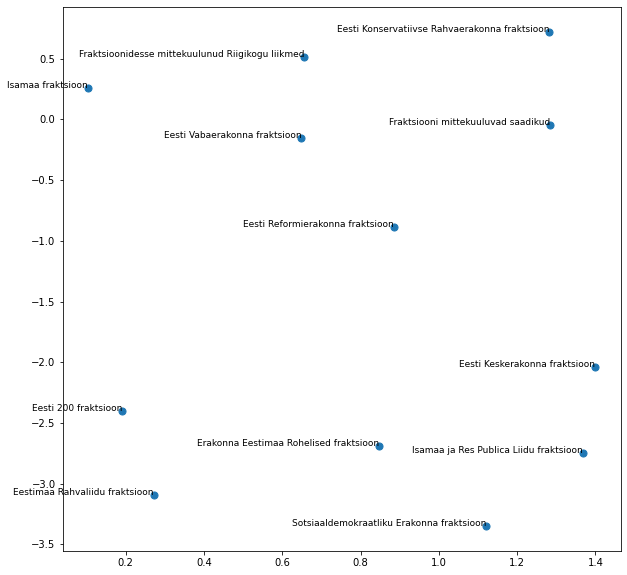

In [147]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
plt.scatter(reduced_avg_latent_embeddings[:, 0], reduced_avg_latent_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.text(reduced_avg_latent_embeddings[i, 0], reduced_avg_latent_embeddings[i, 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

In [187]:
find_word_score_corr(faction_texts, factions2keep, reduced_avg_latent_embeddings[:, 0]).head(30)

,word,correlation
310,peab,0.647750
377,saab,0.639693
495,tänu,0.582975
405,selle,0.574074
167,kõige,0.518200
217,maksude,0.518200
284,olema,0.518200
471,toimub,0.518200
65,ei,0.480930
286,oleme,0.480384


In [188]:
find_word_score_corr(faction_texts, factions2keep, reduced_avg_latent_embeddings[:, 1]).head(30)

,word,correlation
128,kas,0.751068
203,ma,0.677638
282,oleks,0.591312
544,võimalik,0.532181
214,makse,0.529620
225,maksusüsteemi,0.529620
270,neid,0.518200
224,maksustamise,0.518200
266,nagu,0.518200
28,arvan,0.518200


## PCA

IndexError: list index out of range

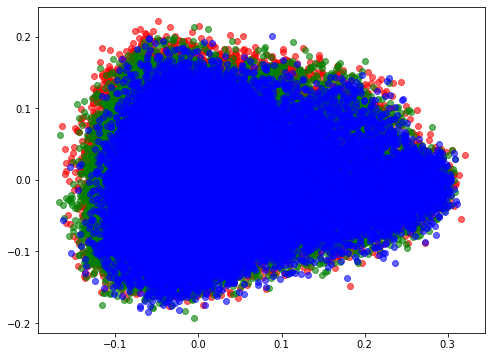

In [189]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Example: Simulate embeddings for 3 different speakers with different numbers of texts
embedding_dim = vec.shape[-1]

# Step 1: Combine all embeddings into a single matrix
all_embeddings = np.vstack(speaker_embeddings)

# Step 2: Apply PCA to reduce dimensions from 300 to 50
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
tsne_embeddings=pca_embeddings
# Step 3: Apply t-SNE to further reduce dimensions to 2D or 3D for visualization
#tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
#tsne_embeddings = tsne.fit_transform(pca_embeddings)

# umap_reducer = umap.UMAP(n_components=2, random_state=42)
# tsne_embeddings = umap_reducer.fit_transform(all_embeddings)

# Step 4: Split the t-SNE embeddings back by speaker based on the original number of texts
num_texts_per_speaker = [embeddings.shape[0] for embeddings in speaker_embeddings]
start_idx = 0
tsne_speaker_embeddings = []

for num_texts in num_texts_per_speaker:
    end_idx = start_idx + num_texts
    tsne_speaker_embeddings.append(tsne_embeddings[start_idx:end_idx])
    start_idx = end_idx

# # Visualize the 2D t-SNE embeddings by speaker
# plt.figure(figsize=(8, 6))
# colors = ['r', 'g', 'b']

# for i, speaker_embedding in enumerate(tsne_speaker_embeddings):
#     plt.scatter(speaker_embedding[:, 0], speaker_embedding[:, 1], color=colors[i], label=f'Speaker {i+1}', alpha=0.6)

# plt.title('t-SNE of Text Embeddings by Speaker')
# plt.legend()
# plt.show()


In [190]:
speaker_tsne_avg_embeddings=[]
for i, speaker_embedding in enumerate(tsne_speaker_embeddings):
    speaker_tsne_avg_embeddings.append(np.mean(speaker_embedding, axis=0))
    #print(f"Speaker {i + 1} Latent Embeddings: {speaker_tsne_avg_embeddings.shape}")

In [191]:
speaker_tsne_avg_embeddings

[array([-0.00029891,  0.0083112 ], dtype=float32),
 array([-0.0047107 , -0.00524277], dtype=float32),
 array([ 0.01649691, -0.0061483 ], dtype=float32),
 array([-0.00674353, -0.00050347], dtype=float32),
 array([-3.3239518e-05, -3.1546389e-03], dtype=float32),
 array([-0.00993837,  0.00526784], dtype=float32),
 array([-0.00036255,  0.01170319], dtype=float32),
 array([-0.00517018, -0.02038255], dtype=float32),
 array([-0.02183961, -0.00822081], dtype=float32),
 array([0.0048216 , 0.00414416], dtype=float32),
 array([ 0.00073354, -0.00316189], dtype=float32),
 array([-0.00330486,  0.00289942], dtype=float32)]

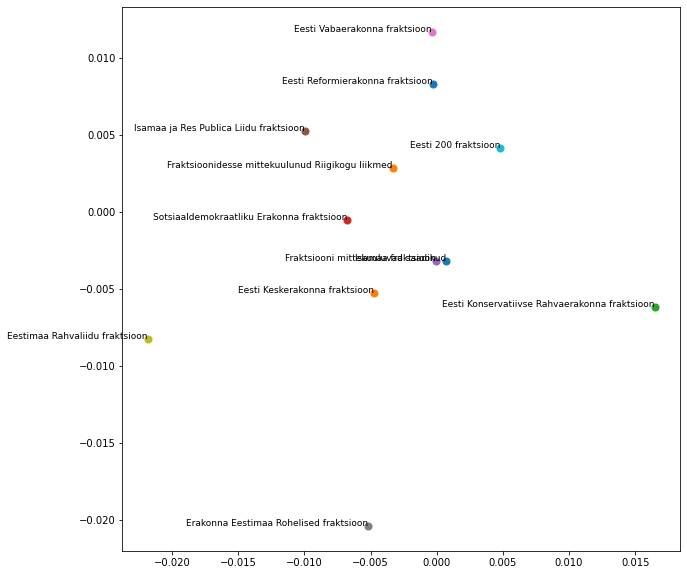

In [192]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
#plt.scatter(speaker_tsne_avg_embeddings[:, 0], speaker_tsne_avg_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.scatter(speaker_tsne_avg_embeddings[i][ 0], speaker_tsne_avg_embeddings[i][ 1], s=50)
    plt.text(speaker_tsne_avg_embeddings[i][ 0], speaker_tsne_avg_embeddings[i][ 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

In [195]:
find_word_score_corr(faction_texts, factions2keep, [speaker_tsne_avg_embeddings[i][ 0] for i in range(len(speaker_tsne_avg_embeddings))]).head(30)

,word,correlation
128,kas,0.705548
538,välja,0.647750
544,võimalik,0.591312
224,maksustamise,0.582975
186,lihtsalt,0.582975
270,neid,0.582975
266,nagu,0.582975
410,selline,0.543197
282,oleks,0.532181
214,makse,0.529620


In [196]:
find_word_score_corr(faction_texts, factions2keep, [speaker_tsne_avg_embeddings[i][1] for i in range(len(speaker_tsne_avg_embeddings))]).head(30)

,word,correlation
268,need,0.752618
416,sest,0.582975
159,kui,0.559776
448,te,0.514136
123,jätkan,0.480384
451,teenus,0.480384
452,teenuse,0.480384
453,teenusega,0.480384
455,tegemist,0.480384
459,teilt,0.480384
